# Agentic RAG with LangGraph

In [17]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("All imports successful")

All imports successful


In [18]:
load_dotenv()
api_key = os.getenv("paid_api")

if not api_key:
    raise ValueError("API_Key not found. Please set it in your .env file")
print("API key loaded")

API key loaded


In [19]:
## Initialize LLM
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0.5,
    api_key = api_key
)
print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


## Load and Process Documents

In [20]:
file_path = r"c:\Users\owner\Downloads\Article_Research\Artificial Intelligence in the Energy Industry.pdf"

# Check if file exists
if not os.path.exists(file_path):
    print(f"File not found {file_path}")
    print("Please update the file_path variable with your PDF file.")

    #Creating sample documents for demo
    from langchain_core.documents import Document
    pages = [
        Document(page_content="Biochemistry is the study of chemical processes in living organisms.",
                 metadata={"page":1}),
        Document(page_content= "Proteins are made of amino acids and perform many functions in cells.",
                 metadata = {"page":2}),
        Document(page_content="DNA stores genetic information using four nucleotide bases.",
                 metadata={"page":3})
    ]
    print("Using sample documents for demo")
else:
    #Load the pdf
    loader = PyPDFLoader(file_path)
    pages= []

    #Load pages (async loading)
    async for page in loader.alazy_load(): # async prevents memory overload by processing pages from a PDF one by one instead of all at once
        pages.append(page)
    print(f"Loaded {len(pages)} pages from PDF.")

Loaded 11 pages from PDF.


### Split into Chunks

In [21]:
# Create text_splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap=50
)

#Split documents
doc_splits = text_splitter.split_documents(pages)

print(f"Created {len(doc_splits)} chunks")
print(f"\n Sample chunk:")
print(f"{doc_splits[0].page_content[:200]}...")

Created 38 chunks

 Sample chunk:
What is Artiﬁcial Intelligence in
the Energy Industry ?
Deﬁnition
In recent years, Artiﬁcial Intelligence (AI) has gained relevance in a wide variety of
sectors. However, deﬁning the term poses some d...


## Create Vector Store (Chromadb)

In [22]:
#Initilize embeddings
embeddings = OpenAIEmbeddings(
    model = "text-embedding-3-small",
    api_key=api_key
)
print("Embeddings model initialized")

Embeddings model initialized


In [23]:
# Create Chroma vector stor
chroma_path = "./chroma_db_agentic_rag"

#Create vector store from documents
vectorstore = Chroma(
    collection_name="agentic_rag_docs",
    persist_directory=chroma_path,
    embedding_function=embeddings
)

#Add documents
vectorstore.add_documents(documents=doc_splits)
print(f"Vector store created with {len(doc_splits)} chunks")
print(f"Persisted to: {chroma_path}")

Vector store created with 38 chunks
Persisted to: ./chroma_db_agentic_rag


### Test Retrieval

In [24]:
# Test the vector store
test_query = "What is artificial intelligence?"
test_results = vectorstore.similarity_search(test_query, k=2)

print(f"Query: {test_query}")
print(f"\nTop result:")
print(f"{test_results[0].page_content[:200]}...")
print(f"\nRetrieval working!")

Query: What is artificial intelligence?

Top result:
What is Artiﬁcial Intelligence in
the Energy Industry ?
Deﬁnition
In recent years, Artiﬁcial Intelligence (AI) has gained relevance in a wide variety of
sectors. However, deﬁning the term poses some d...

Retrieval working!


## Create Retrieval Tool

In [25]:
@tool
def retrieve_documents(query: str) -> str:
    """
    Search for relevant documents in the knowledge base.
    
    Use this tool when you need information from the document collection
    to answer the user's question. Do NOT use this for:
    - General knowledge questions
    - Greetings or small talk
    - Simple calculations
    
    Args:
        query: The search query describing what information is needed
        
    Returns:
        Relevant document excerpts that can help answer the question
    """
    # Use MMR (Maximum Marginal Relevance) for diverse results
    retriever = vectorstore.as_retriever(
        search_type = "mmr",
        search_kwargs ={"k":5, "fetch_k":10}
    )

    # Retrieve documents
    results = retriever.invoke(query)

    if not results:
        return "No relevant documents found"
    
    formatted = "\n\n---\n\n".join(
        f"Document {i+1}:\n{doc.page_content}"
        for i, doc in enumerate(results)
    )
    return formatted
print("Retrieval tool created")


Retrieval tool created


### Test the Tool

In [26]:
# Test tool directly
test_result = retrieve_documents.invoke({"query": "What is artificial intelligence?"})
print(f"Tool result (first 300 chars): \n{test_result[:300]}...")

Tool result (first 300 chars): 
Document 1:
What is Artiﬁcial Intelligence in
the Energy Industry ?
Deﬁnition
In recent years, Artiﬁcial Intelligence (AI) has gained relevance in a wide variety of
sectors. However, deﬁning the term poses some diﬃculties. Central to Artiﬁcial
Intelligence is that it makes and implements decisions b...


## Build the Agentic RAG System

### System Prompt

In [27]:
system_prompt = SystemMessage(content="""You are a helpful assistant with access to a document retrieval tool.

RETRIEVAL DECISION RULES:

DO NOT retrieve for:
- Greetings: "Hello", "Hi", "How are you"
- Questions about your capabilities: "What can you help with?", "What do you do?"
- Simple math or general knowledge: "What is 2+2?"
- Casual conversation: "Thank you", "Goodbye"

DO retrieve for:
- Questions asking for specific information that would be in documents
- Requests for facts, definitions, or explanations about specialized topics
- Any question where citing sources would improve the answer

Rule of thumb: If the user is asking for information (not just chatting), retrieve first.

When you retrieve documents, cite them in your answer. If documents don't contain the answer, say so.
""")

print("System prompt configured")

System prompt configured


### Define Agent Nodes

In [28]:
# Bind tool to LLM
tools = [retrieve_documents]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to retrieve or answer directly.
    """
    messages = [system_prompt] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide whether to call tools or finish.
    """
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "tools"
    return "__end__"
print("Agent nodes defined")

Agent nodes defined


### Build the Graph

In [29]:
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("Agentic RAG system compiled")

Agentic RAG system compiled


### Visualize

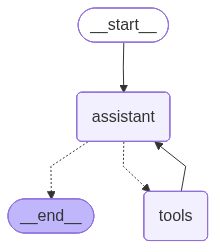

In [30]:
# Visualize the agentic RAG graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")


## Testing the Agentic RAG system

In [32]:
def query_agent(user_input: str, thread_id: str = "default_session"):
    """
    Improved query function with clearer output.
    """
    print(f"\n{'='*70}")
    print(f"User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id":thread_id}}
    )

    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            if message.tool_calls:
                used_retrieval = True
                print(f"Agent: [Calling retrieval tool...]")
            if message.content and not message.tool_calls:
                final_answer = message.content
    
    if final_answer:
        print(f"Agent: {final_answer}")
    else:
        print(f"No response generated after retrieval!")
    
    # Summary
    print(f"\nDecision: {'USED RETRIEVAL' if used_retrieval else 'ANSWERED DIRECTLY'}")
    print(f"{'='*70}\n")

In [33]:
query_agent("What role does artificial intelligence play in the energy industry?")


User: What role does artificial intelligence play in the energy industry?

Agent: [Calling retrieval tool...]
Agent: Artificial intelligence (AI) plays a significant role in the energy industry by enhancing efficiency, security, and decision-making processes. Here are some key areas where AI is applied:

1. **Electricity Trading**: AI algorithms can analyze market trends and optimize trading strategies, leading to more efficient electricity trading operations.

2. **Smart Grids**: AI contributes to the management of smart grids by analyzing data from various sources to improve the distribution and consumption of electricity.

3. **Sector Coupling**: AI facilitates the integration of different energy sectors, such as electricity, heat, and transport, enabling a more cohesive energy system.

4. **Data Analysis**: With the vast amounts of data generated in the energy sector, AI helps in analyzing and evaluating this data, making the industry more efficient and secure.

5. **Energy Transi

In [34]:
query_agent("Hello! What can you help me with?", thread_id="session2")


User: Hello! What can you help me with?

Agent: I'm here to assist you with specific information, facts, definitions, or explanations on specialized topics. If you have a question or need information, feel free to ask!

Decision: ANSWERED DIRECTLY



In [35]:
query_agent("How many roles were listed?")


User: How many roles were listed?

Agent: [Calling retrieval tool...]
Agent: Six roles of artificial intelligence in the energy industry were listed:

1. Electricity Trading
2. Smart Grids
3. Sector Coupling
4. Data Analysis
5. Energy Transition Support
6. Power Consumption Optimization

Decision: USED RETRIEVAL



## Comparison with Traditional RAG

In [ ]:
def traditional_rag(query: str) -> str:
    """
    Traditional RAG: ALWAYS retrieve.
    """
    #Always retrieve
    docs = vectorstore.similarity_search(query, k=3)
    context = "\n\n".join([doc.page_content for doc in docs])

    #Generate answer